## Context and Objective

We want to answer to the following question:
**How much is the expected loss if we acquiere certain type of credit?**

The expected loss at a certain moment is defined as:
                                        **Expected Loss=PD×LGD×EAD**
Where:
- PD: Probability of default
- LGD: Loss given default
- EAD: Exposure at default

The objective of this analysis is to develop an interpretable framework to estimate the Probability of default (PD) of corporate borrowers using financial ratios.The model focuses on identifying early signals of financial distress and understanding the economic drivers behind default risk.

This analysis represents the first building block of a broader credit risk framework, which will later be extended to model Loss Given Default (LGD) and Exposure at Default (EAD) for applications in corporate lending, private credit and distressed debt investing.

## Data Overview


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv('../data/raw/corporate_bankruptcy.csv')
df = df[df['year']==1]
df.drop('year',axis = 1, inplace=True)
df.head()



,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [16]:
df.shape

(7027, 65)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7027 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      7024 non-null   float64
 1   A2      7024 non-null   float64
 2   A3      7024 non-null   float64
 3   A4      6997 non-null   float64
 4   A5      7019 non-null   float64
 5   A6      7024 non-null   float64
 6   A7      7024 non-null   float64
 7   A8      7002 non-null   float64
 8   A9      7026 non-null   float64
 9   A10     7024 non-null   float64
 10  A11     6988 non-null   float64
 11  A12     6997 non-null   float64
 12  A13     7027 non-null   float64
 13  A14     7024 non-null   float64
 14  A15     7025 non-null   float64
 15  A16     7002 non-null   float64
 16  A17     7002 non-null   float64
 17  A18     7024 non-null   float64
 18  A19     7027 non-null   float64
 19  A20     7027 non-null   float64
 20  A21     5405 non-null   float64
 21  A22     7024 non-null   float64
 22  A23  

The dataset consists of a large sample of corporate firms. Each observation represents a company at a given point in time,described by a set of numericla financial ratios.

The target value indicates wether the company entered in bankruptcy within the following year, making the data set suitable for modelling one-year Probability Default (PD).

The variables are primarily continuous and exhibit missing values, which reflect the noisy nature os real-world financial reporting.

## Target Analysis

In [18]:
df['class'].value_counts()

class
0    6756
1     271
Name: count, dtype: int64

In [19]:
df['class'].value_counts(normalize=True)

class
0    0.961434
1    0.038566
Name: proportion, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

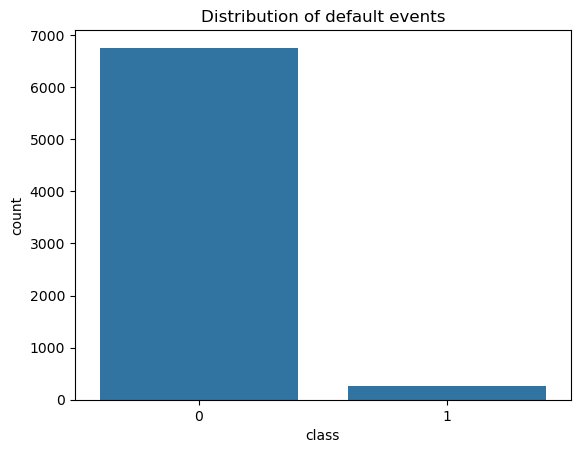

In [20]:
sns.countplot(x='class', data = df)
plt.title('Distribution of default events')
plt.show

The target variable indicates wether a firm entered bankruptcy in the following year. The distribution of the dataset is highly imbalanced, with only a small part of it representing bankrupted firms.

This imbalance reflects the reality of corporate credit-risk, where default is rare but a very significant economic event. As a consequence, standard accuracy metrics are not informative, and model performance will be later evaluated by metrics such as AUC, KS and calibration metrics.

## Ratio Selection

Corporate financial distress is usually driven by a set of economic dimensions related to the firm's financial conditions. This dimensions are consistently documented in finance literature and include ratios from leverage, profitability, liquidity, operational efficiency and firm size.

Using the documented definitions of our dataset ratios, an initial subset of variables will be selected to ensure economic diversity among this subset.
The objective of this selection is not to identify the most predictive variables, but to define an starting point for EDA.

This economic-based selection will then be evaluated and refined by a subsequent EDA qhere the statistical behaviour, redundancy and and correaltion of the variables with default risk is assessed.

In [21]:
df.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
       'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31',
       'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41',
       'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',
       'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61',
       'A62', 'A63', 'A64', 'class'],
      dtype='object')

In [22]:
selected_features = [
    'A1', #ROA
    'A7', # EBIT/Total assets
    'A2', #total liabilities/total assets
    'A8', #equity/total liabilities
    'A4', #current assets/short-term liabilities or current ratio
    'A46', #(current assets-inventory)/short term liabilities or quick ratio
    'A9', #sales/total assets or asset turnover
    'A29', #firm size
]


Additional ratios may be introduced or removed later on in further stages of the analysis based on empirical evidence and model behaviour.

## Exploratory Data Analysis

In [31]:
feautures = selected_features.copy()

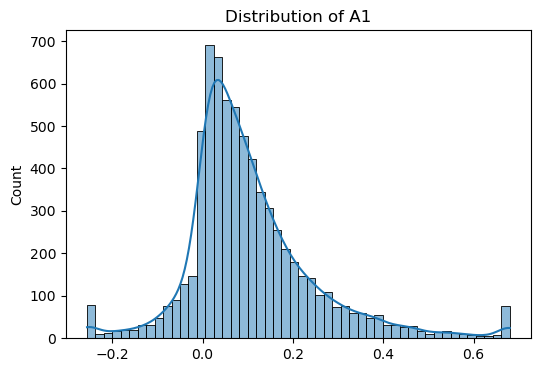

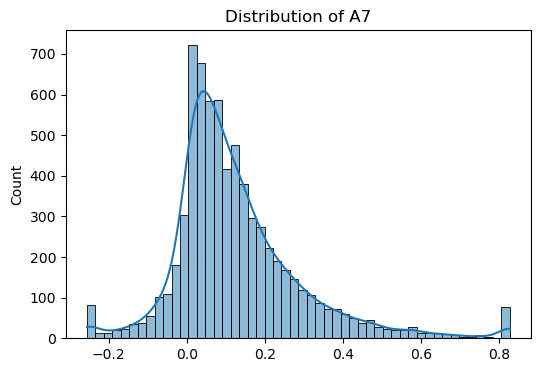

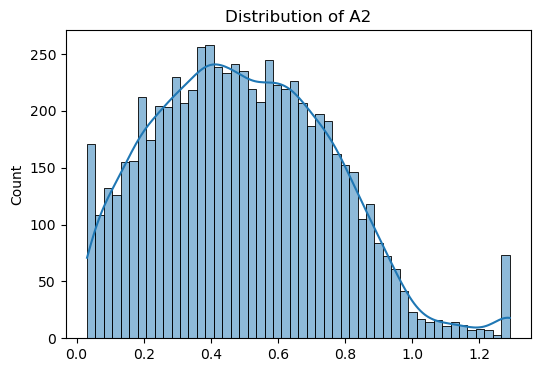

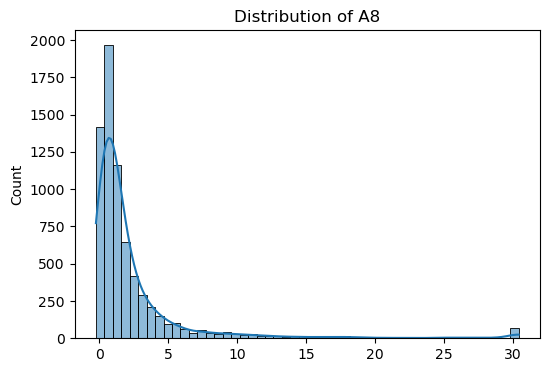

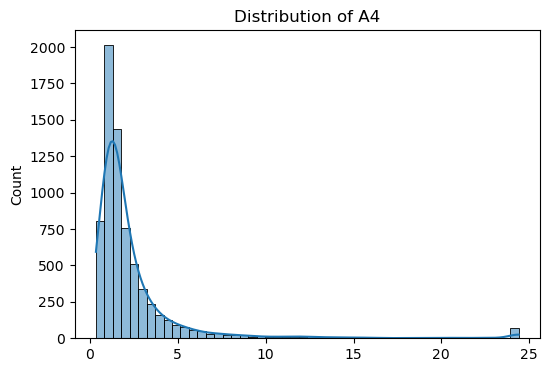

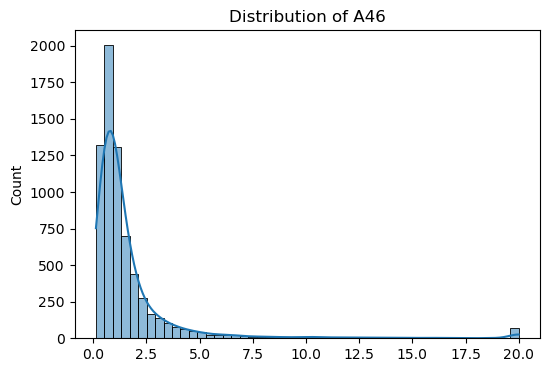

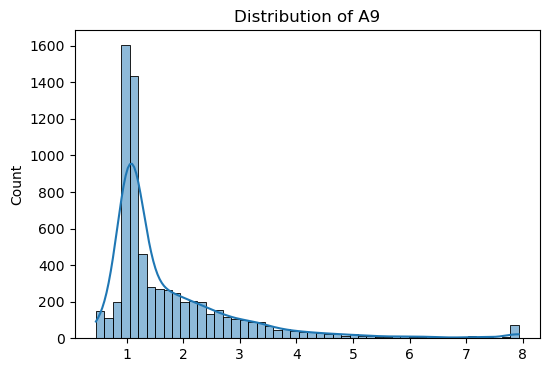

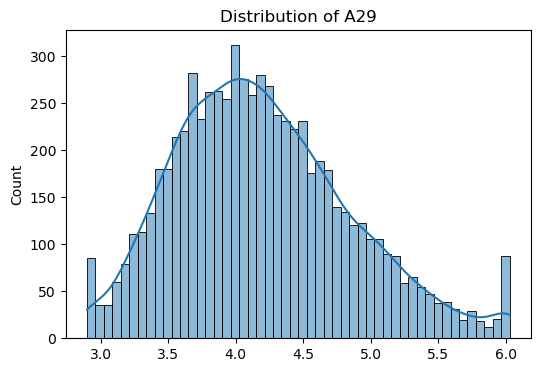

In [30]:
from scipy.stats.mstats import winsorize

def winsorize_series(s,limits=(0.01,0.01)):
    return pd.Series(
        winsorize(s,limits = limits),
        index=s.index
    )
for feature in features:
    plt.figure(figsize=(6,4))
    sns.histplot(winsorize_series(df[feature]).dropna(),
                 bins=50,
                 kde = True
                )
    plt.title(f'Distribution of {feature}')
    plt.show

The distributions of the selected financial ratios exhibit shapes that are consistent with typical financial data, including skewness and heavy tails.
Profitability ratios show asymetric distributions with bot positive and negative values, while leverage and liquidity ratios shwo dispersion across firms.

No variable exhibit degenerate behaviour or lack of variance, suggetsing that all are suitable for futher analysis.

Some of them exhibit extreme values,, wich may require preprocessing after modelling.

In [32]:
df_healthy = df[df['class']==0]
df_default = df[df['class']==1]

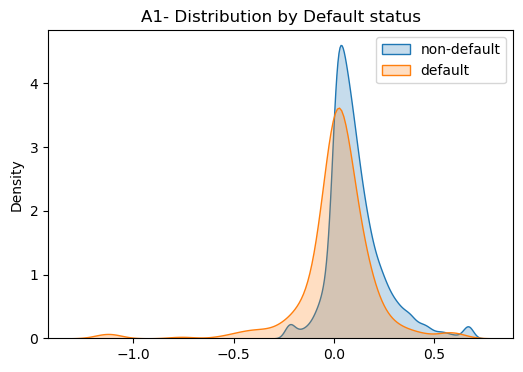

In [44]:
feature = 'A1' #ROA

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The profitabilioty ratio A1 exhibits a letfward shift for defaulted firms, which indicates a poor performance prior to bankruptcy. Although there is a substantial overlap between classes, the observed displacement is economically intuitive and suggests a high discriminatory power when combined with other ratios.

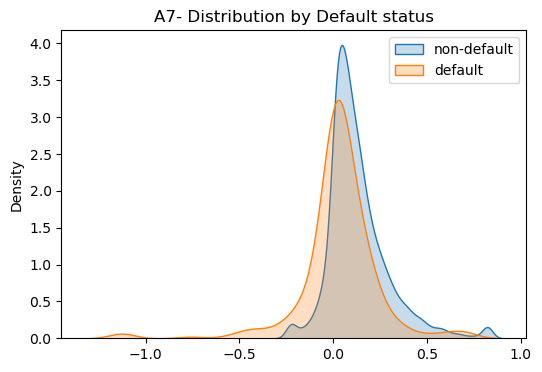

In [36]:
feature = 'A7' # EBIT/Total assets

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The Ebit-to assets ratio shows a similar dsitribution to A1 (leftward shift of the defaulted firms). This suggests a potential redundancy, althoug A7 may provide a cleaner measure of operational distressed as it doesnt takes into account capital structure.

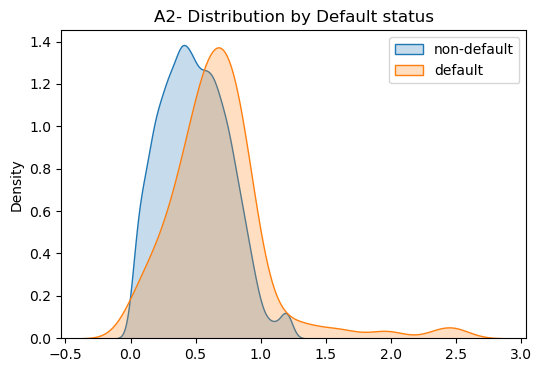

In [37]:
feature = 'A2'  #total liabilities/total assets

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The leverage ratios displays a clear displacement to the right for the defaulted firms, indicating higher level of indebtedness prios to bankruptcy.
This pattern is strongly consistend with distress theory and the clear separation suggest that leverage is a key standalone driver for default risk.

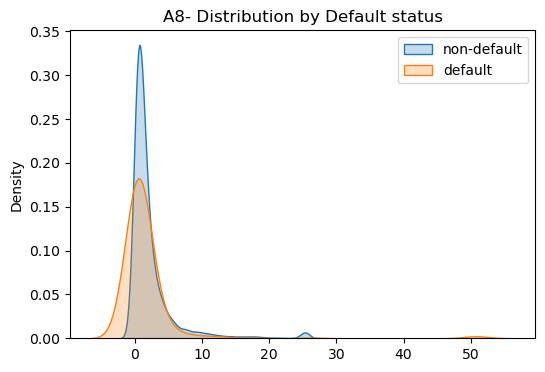

In [38]:
feature = 'A8' #equity/total liabilities

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The equity to liabilities ratio shows an imortant overlap between defaulted and non-defaulted firms, which indicates it limited standalone discriminatory power.
However, given its direct link to a firm's capital structure, the variable is expected to provide additional infomratios when combined with leverage and profitability ratios.

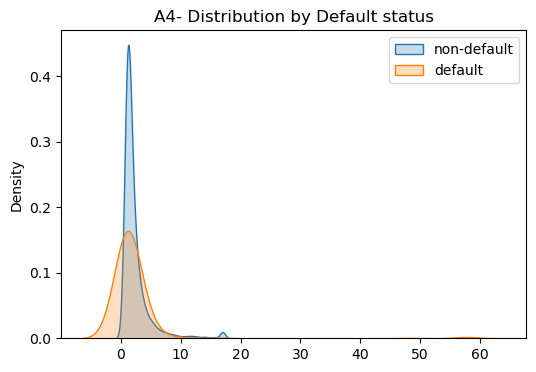

In [40]:
feature = 'A4' #current assets/short-term liabilities or current ratio

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The Current ratio shows a visible domination of the left side by the defaulted firms, although there is a high overlaped area. 

This states a limited standalone discriminatory power, but also indicates that, when combined with other ratios such as leverage, can privide valuable information.

Despite the heavy tails, the observed pattern is economically intuitive and supports the inclusion of liquidity measures in the PD model.

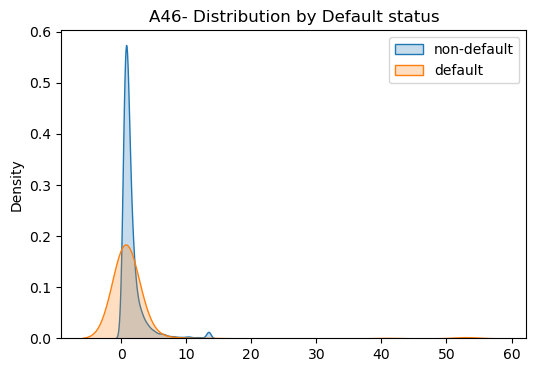

In [41]:
feature = 'A46' #(current assets-inventory)/short term liabilities or quick ratio

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The Quick ratio exhibits a similar distribution to that of the Current ratio, which indicates the possibility of certain redundance.

While the individual separation is moderate, , the variable provides a stricter measure of liquidity and may complement broader liquidity indicators in a multivariate framework.

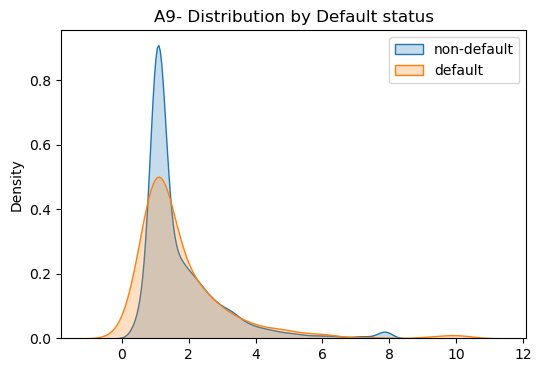

In [42]:
feature = 'A9' #sales/total assets or asset turnover

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

The asset turnover ratio shows a substantial overlap between defaulted and non-defaulted firms,suggesting again, limited individual discriminatory power.

Nevertheless, the variable captures operational efficiency, that, in combination with other financial ratios, can be a valuable information.

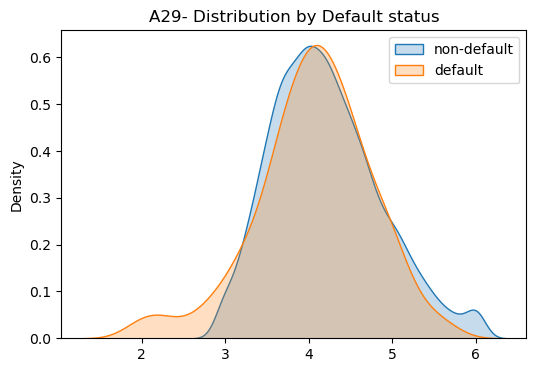

In [43]:
feature = 'A29' # firm size

plt.figure(figsize=(6,4))

sns.kdeplot(
    winsorize_series(df_healthy[feature].dropna()),
    label = 'non-default',
    fill = True
)

sns.kdeplot(
    winsorize_series(df_default[feature].dropna()),
    label = 'default',
    fill = True
)

plt.title(f'{feature}- Distribution by Default status')
plt.legend()
plt.show()

Firm size, measured by the logarithm of total assets (A29), shows that defaulted firms tend to be slightly smaller on average. While size alone does not strongly discriminate defaults, it serves as an important structural control variable that enhances model stability

The comparison between defaulted and non-deafulted firms reveals intuitive economic patterns that support distress theory:
defaulted firms tend to exhibit: 
1. weaker profitability
2. higer leverage 
3. reduced liquidity

While individual variables shows verying degrees of overlap, their combined behaviours support their inclusion in a multivariate default risk model.
